# CNN/RNN/Transformer features + regression[ok]

In [1]:
# 导入包
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np
import itertools

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine Learning Tools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# File Loading Tools 
import os
import pickle


# Deep Learning Tools
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Dropout
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers import Conv2D, MaxPool2D
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
import torch
import torch.nn as nn

In [4]:
import utils.functions_plot as PL

# Load Data

In [5]:
# Load Data 
X_train = np.load("./data phm 2016/X_train_r_modeI_chamber4_mm.npy")
y_train = np.load("./data phm 2016/y_train_modeI_chamber4_mm.npy")
X_test = np.load("./data phm 2016/X_test_r_modeI_chamber4_mm.npy")
y_test = np.load("./data phm 2016/y_test_modeI_chamber4_mm.npy")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

# Basic parameter
wafer_number, max_batch_length, variable_number = X_train.shape
wafer_number_test = X_test.shape[0]
print('训练集晶圆个数：', wafer_number)
print('最长时间序列长度：', max_batch_length)
print('字段个数：', variable_number)
print('训练集晶圆个数：', wafer_number_test)

X_train shape:  (798, 263, 19)
y_train shape:  (798, 1)
X_test shape:  (165, 263, 19)
y_test shape:  (165, 1)
训练集晶圆个数： 798
最长时间序列长度： 263
字段个数： 19
训练集晶圆个数： 165


# 2. Extract Model Features

In [6]:
# extract cnn/rnn/ features
def extract_deep_features(model_name, layer_name):
    model = load_model(f'./results_save/deep_learning_results_10times/{model_name}.h5')
    layer = model.get_layer(layer_name).output
    intermediate_layer_model = Model(inputs=model.input, outputs=layer)
    # pre train and test for conv1d layer
    layer_output_train = intermediate_layer_model.predict(X_train)
    layer_output_test = intermediate_layer_model.predict(X_test)
    print(model_name, layer_output_train.shape, layer_output_test.shape)
    return layer_output_train, layer_output_test

In [7]:
conv1d_output_train, conv1d_output_test = extract_deep_features('model_conv1d', 'flatten')
conv2d_output_train, conv2d_output_test = extract_deep_features('model_conv2d', 'flatten_9')
lstm_output_train, lstm_output_test = extract_deep_features('model_lstm', 'lstm2')
bilstm_output_train, bilstm_output_test = extract_deep_features('model_bilstm', 'biLSTM2')
rnn_output_train, rnn_output_test = extract_deep_features('model_rnn', 'simple_rnn_19')
gru_output_train, gru_output_test = extract_deep_features('model_gru', 'gru_19')

model_conv1d (798, 64) (165, 64)
model_conv2d (798, 544) (165, 544)
model_lstm (798, 40) (165, 40)
model_bilstm (798, 80) (165, 80)
model_rnn (798, 40) (165, 40)
model_gru (798, 40) (165, 40)


In [8]:
# extract transformer features
tf_output_train = pickle.load(open('./results_save/tensforflow_without_validation/features_tf_withoutPE_train.pkl', 'rb'))
tf_output_test = pickle.load(open('./results_save/tensforflow_without_validation/features_tf_withoutPE_test.pkl', 'rb'))
print('model_tf', tf_output_train.shape, tf_output_test.shape)

model_tf (798, 263) (165, 263)


# Some test

In [34]:
def regression_predict(model, model_name, X_train, y_train, X_test, y_test):
    y_train = y_train.reshape((798,))
    y_test = y_test.reshape((165,))
    
    model.fit(X_train, y_train)
    y_test_pre = model.predict(X_test)
    y_test_pre = y_test_pre.reshape((165,))
    
    print(model_name)
    PL.plot_predict_curve(y_test, y_test_pre)

In [35]:
def single_model(output_train, output_test):
    clf_ada = AdaBoostRegressor()
    clf_rf = RandomForestRegressor()
    clf_xgb = XGBRegressor()
    clf_lgbm = LGBMRegressor()
    models = [clf_ada, clf_rf, clf_xgb, clf_lgbm]
    models_name = ['Adaboost', 'RandomForest', 'Xgboost', 'LightGBM']
    for i, model in enumerate(models):
        regression_predict(model, models_name[i], output_train, y_train, output_test, y_test)

In [11]:
# output_train = np.hstack([conv1d_output_train, gru_output_train, tf_output_train])
# output_test = np.hstack([conv1d_output_test, gru_output_test, tf_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d + gru + transformer:')
# single_model(output_train, output_test)

In [12]:
# output_train = np.hstack([conv1d_output_train, gru_output_train])
# output_test = np.hstack([conv1d_output_test, gru_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d + gru:')
# single_model(output_train, output_test)

In [13]:
# output_train = np.hstack([conv1d_output_train])
# output_test = np.hstack([conv1d_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d:')
# single_model(output_train, output_test)

In [14]:
# output_train = np.hstack([gru_output_train])
# output_test = np.hstack([gru_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('gru:')
# single_model(output_train, output_test)

In [15]:
# output_train = np.hstack([tf_output_train])
# output_test = np.hstack([tf_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('transformer:')
# single_model(output_train, output_test)

In [16]:
# output_train = np.hstack([gru_output_train, tf_output_train])
# output_test = np.hstack([gru_output_test, tf_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('gru + transformer:')
# single_model(output_train, output_test)

In [17]:
# output_train = np.hstack([conv1d_output_train, tf_output_train])
# output_test = np.hstack([conv1d_output_test, tf_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d + transformer:')
# single_model(output_train, output_test)

In [18]:
# output_train = np.hstack([lstm_output_train])
# output_test = np.hstack([lstm_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('lstm:')
# single_model(output_train, output_test)

In [19]:
# output_train = np.hstack([conv1d_output_train, lstm_output_train])
# output_test = np.hstack([conv1d_output_test, lstm_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d + lstm:')
# single_model(output_train, output_test)

In [20]:
# output_train = np.hstack([lstm_output_train, gru_output_train])
# output_test = np.hstack([lstm_output_test, gru_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('lstm + gru:')
# single_model(output_train, output_test)

In [21]:
# output_train = np.hstack([conv1d_output_train, lstm_output_train, gru_output_train])
# output_test = np.hstack([conv1d_output_test, lstm_output_test, gru_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('conv1d + lstm + gru:')
# single_model(output_train, output_test)

In [22]:
# output_train = np.hstack([bilstm_output_train])
# output_test = np.hstack([bilstm_output_test])
# print('deep_feature:', output_train.shape)
# print('bilstm:')
# single_model(output_train, output_test)

In [23]:
# output_train = np.hstack([rnn_output_train])
# output_test = np.hstack([rnn_output_test])
# print('deep_feature:', output_train.shape)
# print('rnn:')
# single_model(output_train, output_test)

In [24]:
# output_train = np.hstack([conv2d_output_train])
# output_test = np.hstack([conv2d_output_test])
# print('deep_feature:', output_train.shape)
# print('conv2d:')
# single_model(output_train, output_test)

In [25]:
# output_train = np.hstack([bilstm_output_train, gru_output_train])
# output_test = np.hstack([bilstm_output_test, gru_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('bilstm + gru:')
# single_model(output_train, output_test)

In [26]:
# output_train = np.hstack([bilstm_output_train, conv1d_output_train])
# output_test = np.hstack([bilstm_output_test, conv1d_output_test])
# print('deep_feature:', output_train.shape, output_test.shape)
# print('bilstm + conv1d:')
# single_model(output_train, output_test)

# combination

In [27]:
def predict_compute(model, model_name, X_train, y_train, X_test, y_test):
    y_train = y_train.reshape((798,))
    y_test = y_test.reshape((165,))
    
    model.fit(X_train, y_train)
    y_test_pre = model.predict(X_test)
    y_test_pre = y_test_pre.reshape((165,))
    
    mse = mean_squared_error(y_test, y_test_pre)  # 均方误差，越小越好
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pre))  # 根均方误差，越小越好
    mae = mean_absolute_error(y_test, y_test_pre)  # 平均绝对误差，越小越好
    r2 = r2_score(y_test, y_test_pre)  # r2 score 满分1，越接近1越好
    
    error = abs(y_test_pre - y_test)
    mae_max = error.max(); mae_min = error.min(); mae_mean = error.mean(); mae_std = error.std()
    
    return mse, rmse, mae, r2, mae_max, mae_min, mae_mean, mae_std

In [28]:
def ensemble_model(output_train, output_test):
    clf_ada = AdaBoostRegressor()
    clf_rf = RandomForestRegressor()
    clf_xgb = XGBRegressor()
    clf_lgbm = LGBMRegressor()
    models = [clf_ada, clf_rf, clf_xgb, clf_lgbm]
    models_name = ['Adaboost', 'RandomForest', 'Xgboost', 'LightGBM']
    result = []
    for i, model in enumerate(models):
        mse, rmse, mae, r2, mae_max, mae_min, mae_mean, mae_std = predict_compute(model, models_name[i], output_train, y_train, output_test, y_test)
        result.append(mse)
    return result

In [29]:
model_names = ['conv1d', 'conv2d', 'lstm', 'bilstm', 'gru', 'rnn', 'tf']
df = pd.DataFrame()
for n in range(1,len(model_names)+1):
    print(f'{n}: ******************************************************')
    for c in itertools.combinations(model_names, n):
        output_train = np.empty((798,0))
        output_test = np.empty((165,0))
        for model_i in c:
            output_train = np.hstack([output_train, eval(model_i+'_output_train')])
            output_test = np.hstack([output_test, eval(model_i+'_output_test')])
        print(c, output_train.shape, output_test.shape)
        result = ensemble_model(output_train, output_test)
        min_mse = np.min(result)
        argmin_mse = np.argmin(result)
        if argmin_mse==0:
            min_mse_model = 'Adaboost'
        elif argmin_mse==1:
            min_mse_model = 'RandomForest'
        elif argmin_mse==2:
            min_mse_model = 'Xgboost'
        elif argmin_mse==3:
            min_mse_model = 'LightGBM'
        
        df = df.append({'model':c, 
                        'Adaboost_mse':result[0], 
                        'RandomForest_mse':result[1], 
                        'Xgboost_mse':result[2], 
                        'LightGBM_mse':result[3],
                        'min_mse':min_mse,
                        'min_mse_model':min_mse_model}, ignore_index=True)

1: ******************************************************
('conv1d',) (798, 64) (165, 64)
('conv2d',) (798, 544) (165, 544)
('lstm',) (798, 40) (165, 40)
('bilstm',) (798, 80) (165, 80)
('gru',) (798, 40) (165, 40)
('rnn',) (798, 40) (165, 40)
('tf',) (798, 263) (165, 263)
2: ******************************************************
('conv1d', 'conv2d') (798, 608) (165, 608)
('conv1d', 'lstm') (798, 104) (165, 104)
('conv1d', 'bilstm') (798, 144) (165, 144)
('conv1d', 'gru') (798, 104) (165, 104)
('conv1d', 'rnn') (798, 104) (165, 104)
('conv1d', 'tf') (798, 327) (165, 327)
('conv2d', 'lstm') (798, 584) (165, 584)
('conv2d', 'bilstm') (798, 624) (165, 624)
('conv2d', 'gru') (798, 584) (165, 584)
('conv2d', 'rnn') (798, 584) (165, 584)
('conv2d', 'tf') (798, 807) (165, 807)
('lstm', 'bilstm') (798, 120) (165, 120)
('lstm', 'gru') (798, 80) (165, 80)
('lstm', 'rnn') (798, 80) (165, 80)
('lstm', 'tf') (798, 303) (165, 303)
('bilstm', 'gru') (798, 120) (165, 120)
('bilstm', 'rnn') (798, 120) 

In [30]:
df

,Adaboost_mse,LightGBM_mse,RandomForest_mse,Xgboost_mse,min_mse,min_mse_model,model
0,14.054795,14.402458,12.658452,15.551711,12.658452,RandomForest,"(conv1d,)"
1,20.375583,16.710949,17.058561,21.521684,16.710949,LightGBM,"(conv2d,)"
2,17.614423,19.273186,19.240768,18.952773,17.614423,Adaboost,"(lstm,)"
3,12.874237,10.738941,10.056328,11.795559,10.056328,RandomForest,"(bilstm,)"
4,11.881520,10.858152,10.230288,11.910923,10.230288,RandomForest,"(gru,)"
...,...,...,...,...,...,...,...
122,14.021903,12.660842,13.965015,13.158894,12.660842,LightGBM,"(conv1d, conv2d, lstm, gru, rnn, tf)"
123,12.089220,11.936340,11.354389,13.913345,11.354389,RandomForest,"(conv1d, conv2d, bilstm, gru, rnn, tf)"
124,14.199686,13.299807,14.083406,13.682079,13.299807,LightGBM,"(conv1d, lstm, bilstm, gru, rnn, tf)"
125,14.773576,13.644610,14.429644,13.042826,13.042826,Xgboost,"(conv2d, lstm, bilstm, gru, rnn, tf)"


In [31]:
df.sort_values(by=['min_mse'])

,Adaboost_mse,LightGBM_mse,RandomForest_mse,Xgboost_mse,min_mse,min_mse_model,model
47,11.758703,9.780784,9.546722,10.723694,9.546722,RandomForest,"(conv2d, bilstm, gru)"
89,11.985020,9.780506,9.915319,11.098391,9.780506,LightGBM,"(conv2d, bilstm, gru, rnn)"
22,12.414266,9.848776,10.009708,12.292633,9.848776,LightGBM,"(bilstm, gru)"
59,11.589906,10.077890,9.852214,10.569286,9.852214,RandomForest,"(bilstm, gru, rnn)"
25,11.075574,10.126029,9.908761,10.750717,9.908761,RandomForest,"(gru, rnn)"
...,...,...,...,...,...,...,...
5,16.732828,17.337225,16.816132,18.992281,16.732828,Adaboost,"(rnn,)"
21,17.222742,18.431660,16.744535,19.467472,16.744535,RandomForest,"(lstm, tf)"
17,18.738074,17.058390,17.220395,22.627494,17.058390,LightGBM,"(conv2d, tf)"
2,17.614423,19.273186,19.240768,18.952773,17.614423,Adaboost,"(lstm,)"


In [32]:
df.sort_values(by=['min_mse']).head(10)

,Adaboost_mse,LightGBM_mse,RandomForest_mse,Xgboost_mse,min_mse,min_mse_model,model
47,11.758703,9.780784,9.546722,10.723694,9.546722,RandomForest,"(conv2d, bilstm, gru)"
89,11.985020,9.780506,9.915319,11.098391,9.780506,LightGBM,"(conv2d, bilstm, gru, rnn)"
22,12.414266,9.848776,10.009708,12.292633,9.848776,LightGBM,"(bilstm, gru)"
59,11.589906,10.077890,9.852214,10.569286,9.852214,RandomForest,"(bilstm, gru, rnn)"
25,11.075574,10.126029,9.908761,10.750717,9.908761,RandomForest,"(gru, rnn)"
3,12.874237,10.738941,10.056328,11.795559,10.056328,RandomForest,"(bilstm,)"
50,11.371271,10.224552,10.088371,11.359105,10.088371,RandomForest,"(conv2d, gru, rnn)"
15,12.202239,10.195695,10.184152,10.965239,10.184152,RandomForest,"(conv2d, gru)"
4,11.881520,10.858152,10.230288,11.910923,10.230288,RandomForest,"(gru,)"
14,12.441707,10.897251,10.343700,12.158085,10.343700,RandomForest,"(conv2d, bilstm)"


# show Top10 min mse curve

deep_feature: (798, 80)
bilstm:
Adaboost
MSE:  13.027294811757116
RMSE:  3.609334400101647
MAE:  2.88763066413051
R^2:  0.6839850510674048
max absolute error:  12.14382326732678
min absolute error:  0.11063571428572061
mean absolute error:  2.88763066413051
std absolute error:  2.1653830975904254




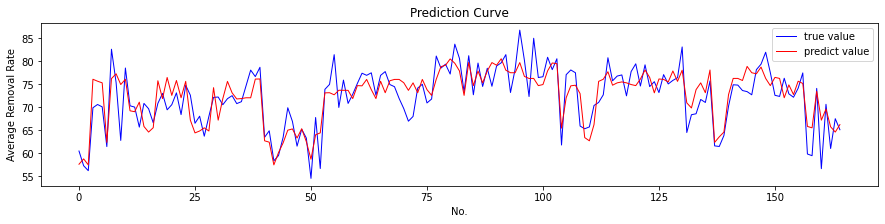

RandomForest
MSE:  10.085920170100104
RMSE:  3.1758337755776993
MAE:  2.4815581727272726
R^2:  0.7553366532692666
max absolute error:  11.654933999999997
min absolute error:  0.029522999999983313
mean absolute error:  2.4815581727272726
std absolute error:  1.981865082560008




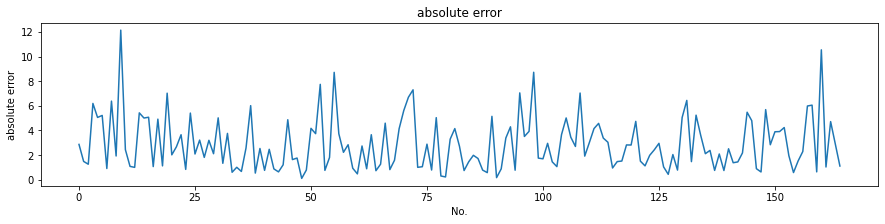

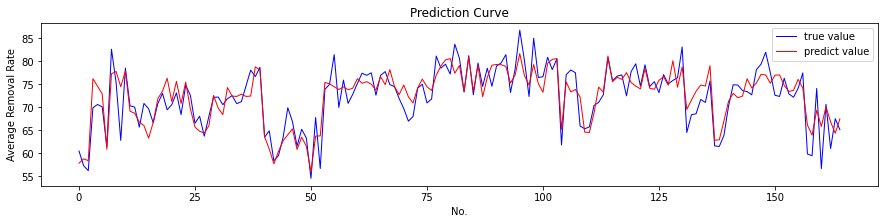

Xgboost
MSE:  11.795559452687733
RMSE:  3.434466399993998
MAE:  2.588465134018406
R^2:  0.7138643769151234
max absolute error:  12.562565393066407
min absolute error:  0.023761474609372613
mean absolute error:  2.588465134018406
std absolute error:  2.257300977419451




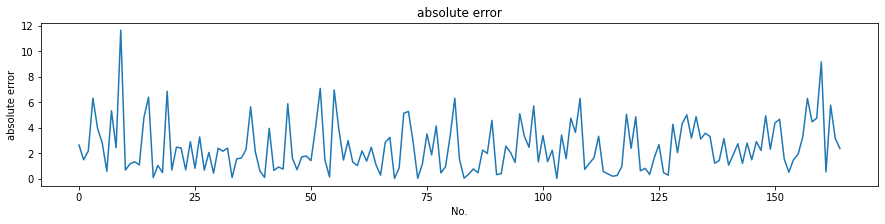

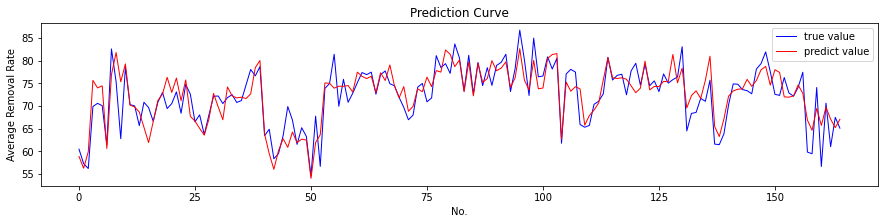

LightGBM
MSE:  10.73894063078971
RMSE:  3.2770322901658613
MAE:  2.5004508395515317
R^2:  0.7394957415129346
max absolute error:  12.009277847108649
min absolute error:  0.035110501211477185
mean absolute error:  2.5004508395515317
std absolute error:  2.1181799332860636




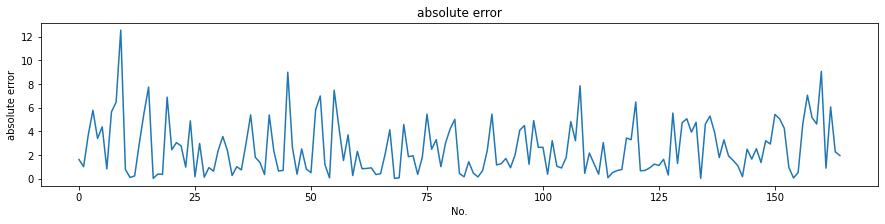

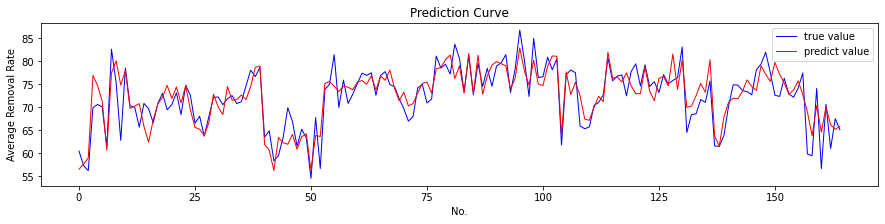

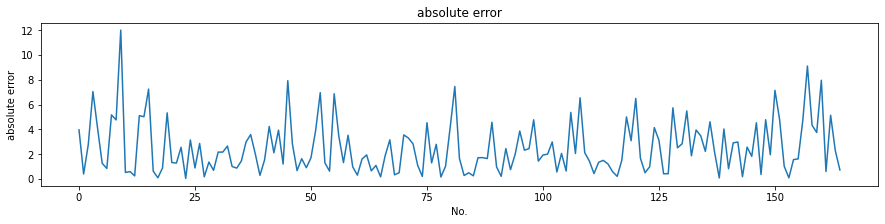

In [36]:
output_train = np.hstack([bilstm_output_train])
output_test = np.hstack([bilstm_output_test])
print('deep_feature:', output_train.shape)
print('bilstm:')
single_model(output_train, output_test)

deep_feature: (798, 40)
gru:
Adaboost
MSE:  12.00190918149146
RMSE:  3.464377170790077
MAE:  2.7122469718616946
R^2:  0.7088587637043657
max absolute error:  11.446762365591368
min absolute error:  0.0021176470588102347
mean absolute error:  2.7122469718616946
std absolute error:  2.1553713241848897




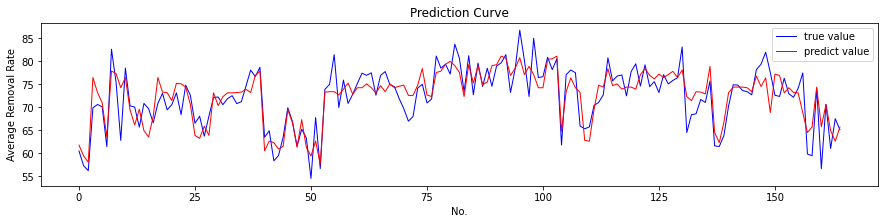

RandomForest
MSE:  10.39420872079795
RMSE:  3.224005074561445
MAE:  2.478583799999994
R^2:  0.7478582172614042
max absolute error:  11.038890000000023
min absolute error:  0.0021524999999797956
mean absolute error:  2.478583799999994
std absolute error:  2.061754366352971




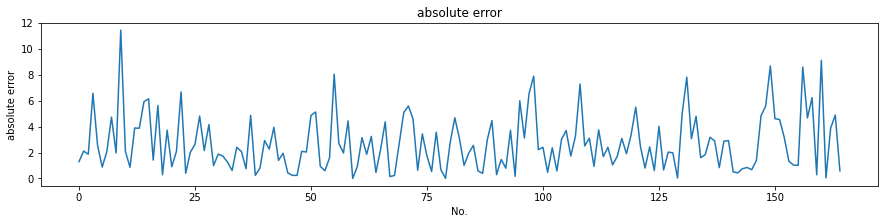

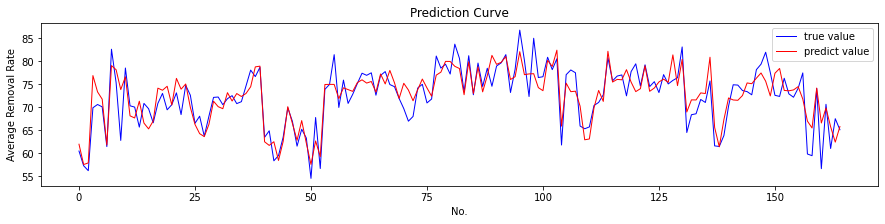

Xgboost
MSE:  11.910922513659843
RMSE:  3.4512204382884386
MAE:  2.6365784125680634
R^2:  0.7110659101306833
max absolute error:  10.24654079589844
min absolute error:  0.014566455078124818
mean absolute error:  2.6365784125680634
std absolute error:  2.2269658255213334




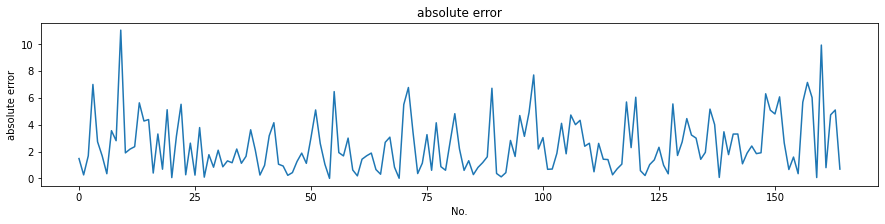

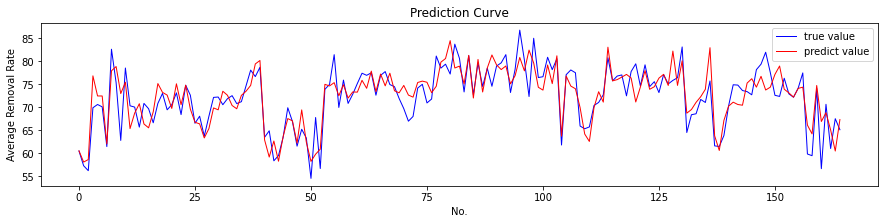

LightGBM
MSE:  10.858152346661596
RMSE:  3.295171064855601
MAE:  2.468160417160214
R^2:  0.7366039144031788
max absolute error:  12.573590179170196
min absolute error:  0.015208274599203264
mean absolute error:  2.468160417160214
std absolute error:  2.183194105393543




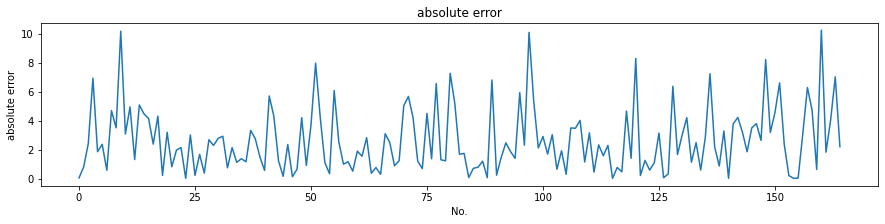

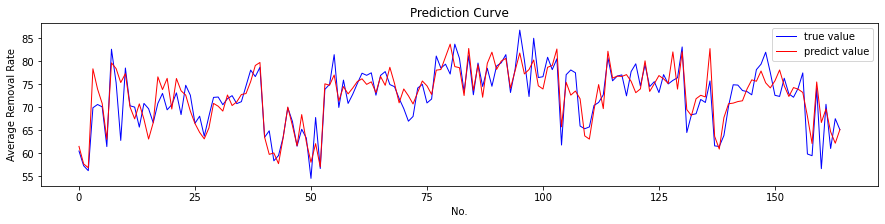

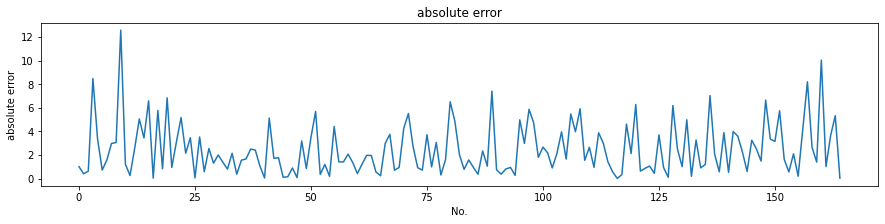

In [37]:
output_train = np.hstack([gru_output_train])
output_test = np.hstack([gru_output_test])
print('deep_feature:', output_train.shape)
print('gru:')
single_model(output_train, output_test)

deep_feature: (798, 120)
bilstm+gru:
Adaboost
MSE:  12.355081079886675
RMSE:  3.514979527662526
MAE:  2.8479094265447498
R^2:  0.7002915514743129
max absolute error:  10.621145270270304
min absolute error:  0.0016567164178837857
mean absolute error:  2.8479094265447498
std absolute error:  2.060216730852419




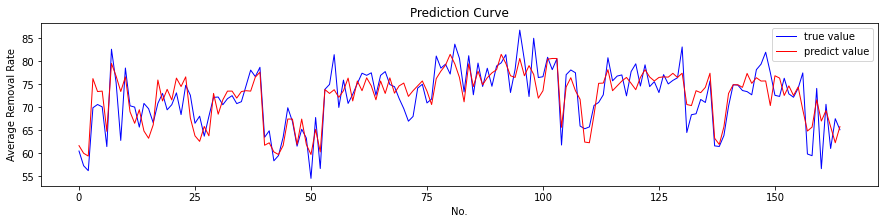

RandomForest
MSE:  9.930617907206463
RMSE:  3.151288293255072
MAE:  2.4292686636363605
R^2:  0.7591039616311805
max absolute error:  11.16946499999996
min absolute error:  0.025170000000017012
mean absolute error:  2.4292686636363605
std absolute error:  2.007304577556897




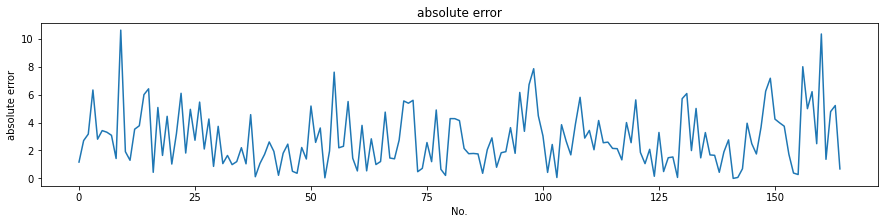

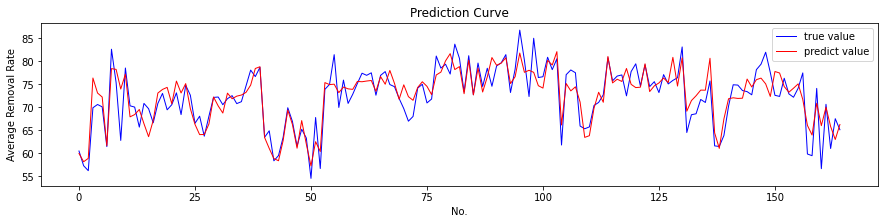

Xgboost
MSE:  12.292632890765326
RMSE:  3.5060851231487984
MAE:  2.7315773204826588
R^2:  0.7018064140441156
max absolute error:  9.658657617187501
min absolute error:  0.01333356933594132
mean absolute error:  2.7315773204826588
std absolute error:  2.1979804896745794




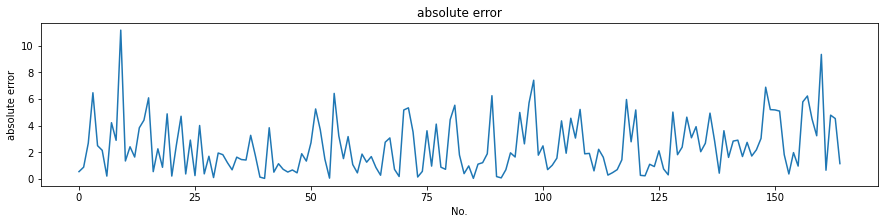

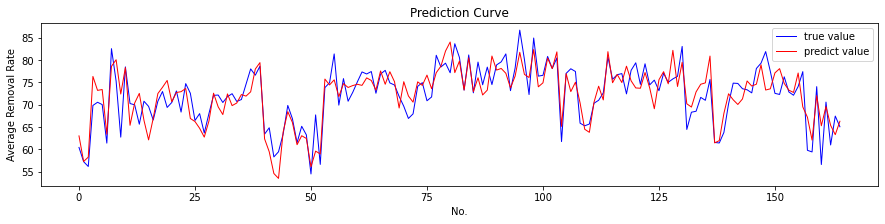

LightGBM
MSE:  9.848775741549805
RMSE:  3.138275918645428
MAE:  2.362650070837245
R^2:  0.7610892815440439
max absolute error:  11.037382722917087
min absolute error:  0.027936583535677073
mean absolute error:  2.362650070837245
std absolute error:  2.0655895972633496




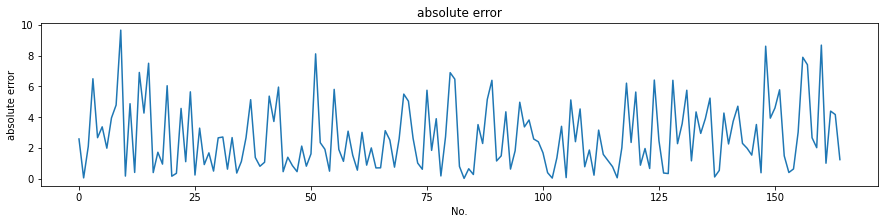

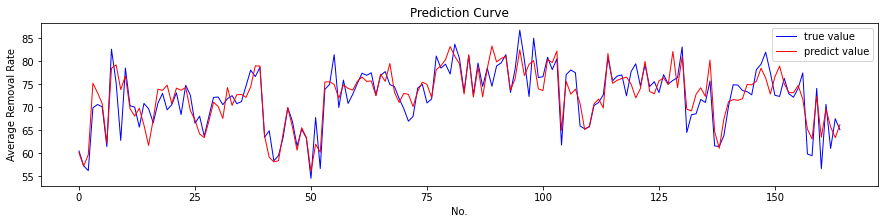

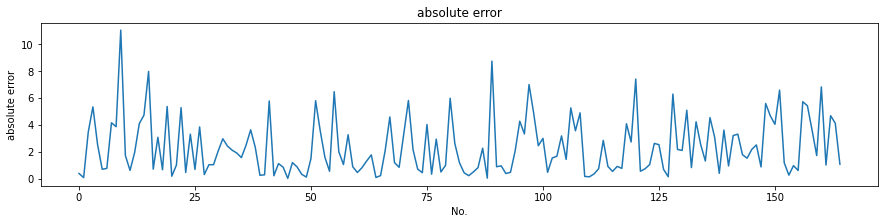

In [38]:
output_train = np.hstack([bilstm_output_train, gru_output_train])
output_test = np.hstack([bilstm_output_test, gru_output_test])
print('deep_feature:', output_train.shape)
print('bilstm+gru:')
single_model(output_train, output_test)

deep_feature: (798, 664)
conv2d+bilstm+gru:
Adaboost
MSE:  11.897165269903242
RMSE:  3.4492267640593366
MAE:  2.708970165265892
R^2:  0.7113996321156401
max absolute error:  11.514523783783758
min absolute error:  0.027354545454514323
mean absolute error:  2.708970165265892
std absolute error:  2.1350985723386477




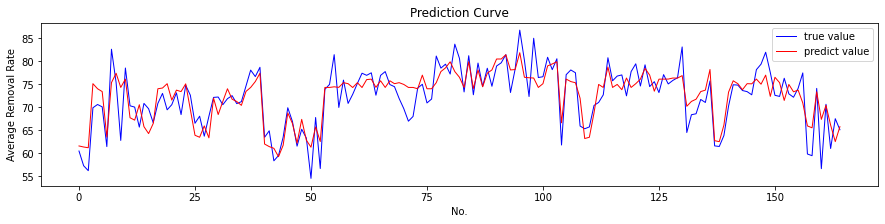

RandomForest
MSE:  9.582492538033046
RMSE:  3.095560133163794
MAE:  2.410832254545455
R^2:  0.7675487556080691
max absolute error:  11.046807000000001
min absolute error:  0.05317950000002725
mean absolute error:  2.410832254545455
std absolute error:  1.9417467338652392




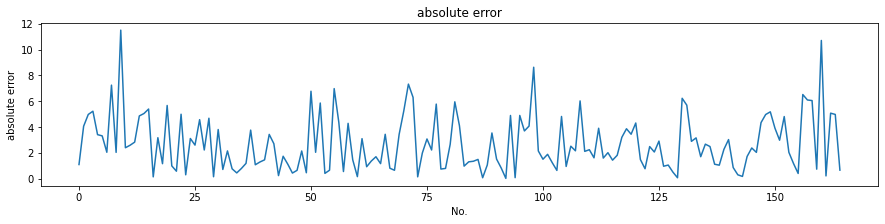

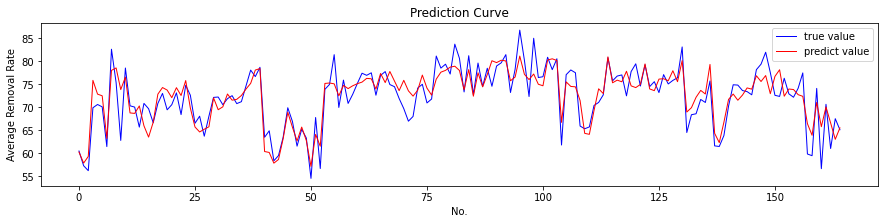

Xgboost
MSE:  10.723694269424294
RMSE:  3.2747052187066084
MAE:  2.539778516919686
R^2:  0.7398655863792649
max absolute error:  9.225669226074217
min absolute error:  0.11532523193359623
mean absolute error:  2.539778516919686
std absolute error:  2.0671766626047074




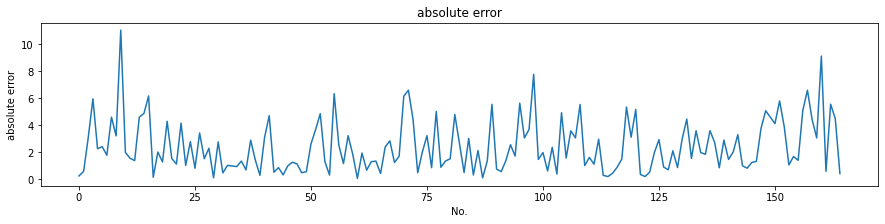

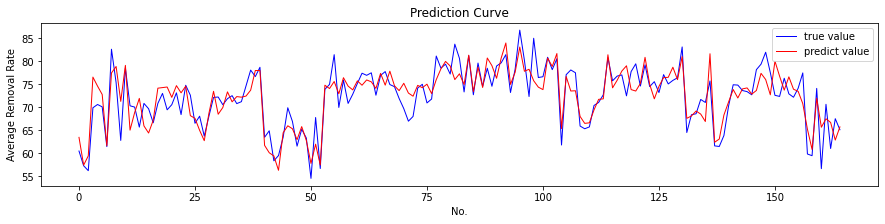

LightGBM
MSE:  9.780783520217593
RMSE:  3.127424422782682
MAE:  2.3696907814297457
R^2:  0.7627386307498913
max absolute error:  10.913006936099833
min absolute error:  0.0006758001378983636
mean absolute error:  2.3696907814297457
std absolute error:  2.0409186952508604




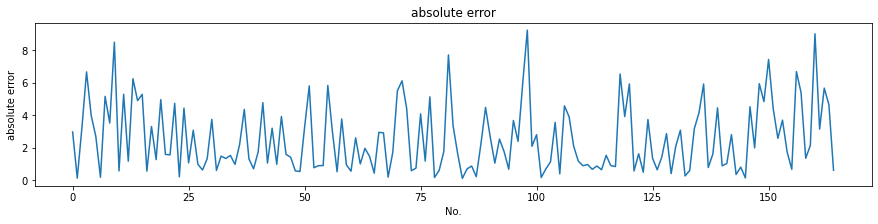

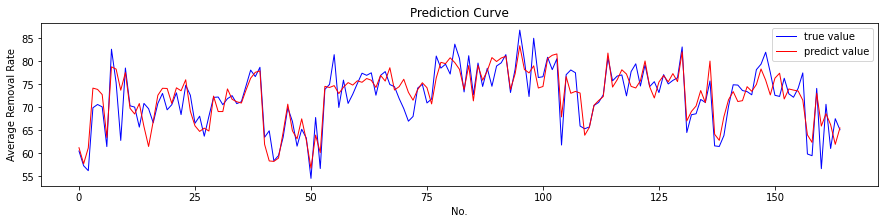

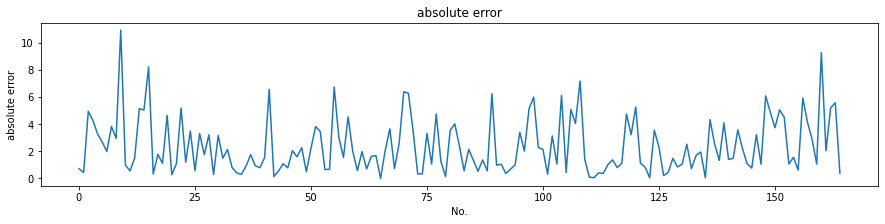

In [39]:
output_train = np.hstack([conv2d_output_train, bilstm_output_train, gru_output_train])
output_test = np.hstack([conv2d_output_test, bilstm_output_test, gru_output_test])
print('deep_feature:', output_train.shape)
print('conv2d+bilstm+gru:')
single_model(output_train, output_test)

deep_feature: (798, 704)
conv2d+bilstm+gru+rnn:
Adaboost
MSE:  11.280379405737836
RMSE:  3.3586276074816386
MAE:  2.6679339751033244
R^2:  0.7263615682799056
max absolute error:  12.561858917197455
min absolute error:  0.04891088235301311
mean absolute error:  2.6679339751033244
std absolute error:  2.040222465866703




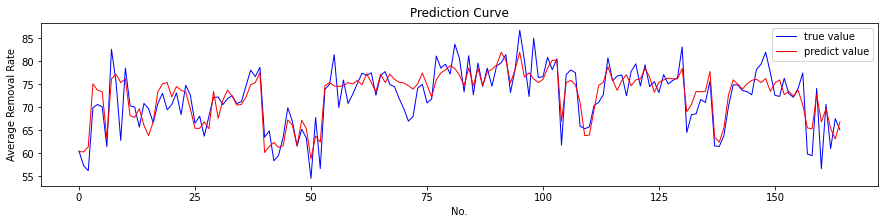

RandomForest
MSE:  10.26216645848233
RMSE:  3.20346163680515
MAE:  2.5277435636363617
R^2:  0.7510612866158304
max absolute error:  11.30792550000001
min absolute error:  0.009070500000007087
mean absolute error:  2.5277435636363617
std absolute error:  1.9679123290881828




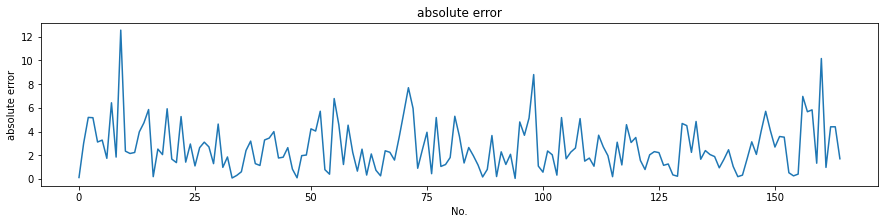

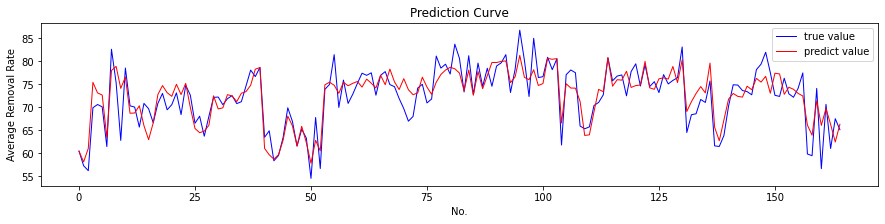

Xgboost
MSE:  11.09839108807824
RMSE:  3.3314247834940294
MAE:  2.5975502377781723
R^2:  0.7307762245644646
max absolute error:  12.26527858886719
min absolute error:  0.0011169189453141826
mean absolute error:  2.5975502377781723
std absolute error:  2.085934766548753




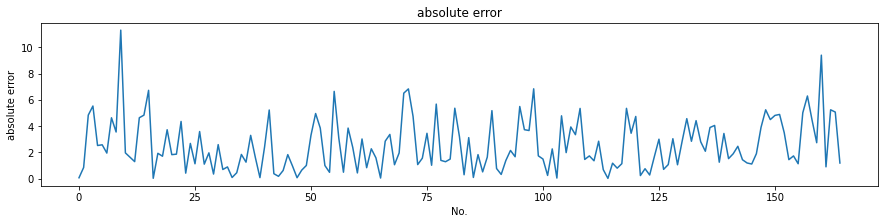

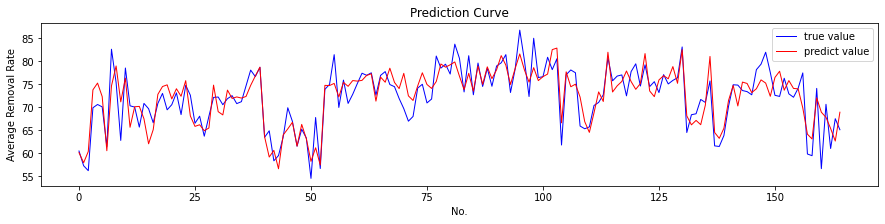

LightGBM
MSE:  9.780506201594427
RMSE:  3.127380085885697
MAE:  2.409026244509532
R^2:  0.7627453579201753
max absolute error:  11.344455039945416
min absolute error:  0.0263035996981813
mean absolute error:  2.409026244509532
std absolute error:  1.9942664703741901




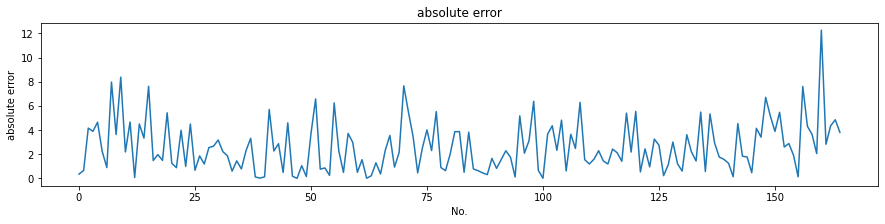

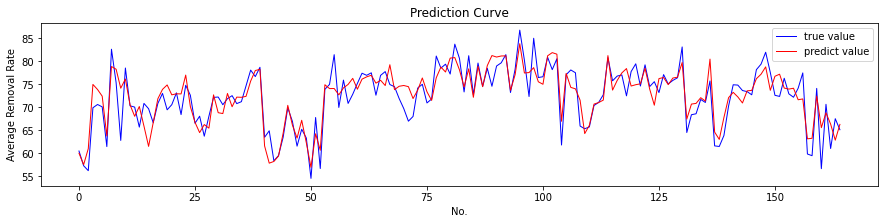

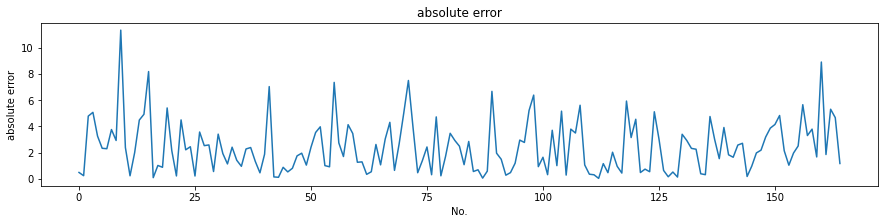

In [40]:
output_train = np.hstack([conv2d_output_train, bilstm_output_train, gru_output_train, rnn_output_train])
output_test = np.hstack([conv2d_output_test, bilstm_output_test, gru_output_test, rnn_output_test])
print('deep_feature:', output_train.shape)
print('conv2d+bilstm+gru+rnn:')
single_model(output_train, output_test)